# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name=r"D:\dev\workspace\deep-reinforcement-learning\p3_collab-compet\Tennis_Windows_x86_64\Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.10000000149011612
Score (max over agents) from episode 5: 0.09000000171363354


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
#import envs
from buffer import ReplayBuffer
from maddpg import MADDPG
import torch
import numpy as np
#from tensorboardX import SummaryWriter
import os
from utilities import transpose_list, transpose_to_tensor

# keep training awake
from workspace_utils import keep_awake

# for saving gif
#import imageio


def seeding(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)

def pre_process(entity, batchsize):
    processed_entity = []
    for j in range(3):
        list = []
        for i in range(batchsize):
            b = entity[i][j]
            list.append(b)
        c = torch.Tensor(list)
        processed_entity.append(c)
    return processed_entity


def main():
    seeding()
    # number of parallel agents
    parallel_envs = 1
    # number of training episodes.
    # change this to higher number to experiment. say 30000.
    number_of_episodes = 10000
    episode_length = 80
    batchsize = 128 #1000
    # how many episodes to save policy and gif
    save_interval = 1000
    t = 0
    
    # amplitude of OU noise
    # this slowly decreases to 0
    noise = 2
    noise_reduction = 0.9999

    # how many episodes before update
    episode_per_update = 4 * parallel_envs

    log_path = os.getcwd()+"/log"
    model_dir= os.getcwd()+"/model_dir"
    
    os.makedirs(model_dir, exist_ok=True)

    torch.set_num_threads(parallel_envs)
    #env = envs.make_parallel_env(parallel_envs)
    
    # keep 5000 episodes worth of replay
    buffer = ReplayBuffer(int(5000*episode_length))
    
    # initialize policy and critic
    maddpg = MADDPG()
    #logger = SummaryWriter(log_dir=log_path)
    agent0_reward = []
    agent1_reward = []
    avg_rewards = []
    #agent2_reward = []

    # training loop
    # show progressbar
    #import progressbar as pb
    #widget = ['episode: ', pb.Counter(),'/',str(number_of_episodes),' ', 
    #          pb.Percentage(), ' ', pb.ETA(), ' ', pb.Bar(marker=pb.RotatingMarker()), ' ' ]
    
    #timer = pb.ProgressBar(widgets=widget, maxval=number_of_episodes).start()

    # use keep_awake to keep workspace from disconnecting
    for episode in range(0, number_of_episodes, parallel_envs):

        #timer.update(episode)


        reward_this_episode = np.zeros((parallel_envs, num_agents)) 
        
        
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        #scores = np.zeros(num_agents)                          # initialize the score (for each agent)

        #all_obs = env.reset() #
        #obs, obs_full = transpose_list(all_obs)

        #for calculating rewards for this particular episode - addition of all time steps

        # save info or not
        save_info = ((episode) % save_interval < parallel_envs or episode==number_of_episodes-parallel_envs)
        frames = []
        tmax = 0
        
        #if save_info:
        #    frames.append(env.render('rgb_array'))


        
        for episode_t in range(episode_length):

            t += parallel_envs
            

            # explore = only explore for a certain number of episodes
            # action input needs to be transposed
            #print(states.shape)
            obs = [states.tolist()]
            actions = maddpg.act(transpose_to_tensor(obs), noise=noise) 
            noise *= noise_reduction
            
            actions_array = torch.stack(actions).detach().numpy()

            # transpose the list of list
            # flip the first two indices
            # input to step requires the first index to correspond to number of parallel agents
            actions_for_env = np.rollaxis(actions_array,1)
            #print(len(actions_for_env[0][0]))
            # step forward one frame
            #next_obs, next_obs_full, rewards, dones, info = env.step(actions_for_env)
            
            
            #actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
            actions_for_env = np.clip(np.array(actions_for_env[0]), -1, 1)                  # all actions between -1 and 1
            env_info = env.step(actions_for_env)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            #scores += env_info.rewards                         # update the score (for each agent)
                                           # roll over states to next time step
            #if np.any(dones):                                  # exit loop if episode finished
            #    break

            
            # add data to buffer
            #transition = (obs, obs_full, actions_for_env, rewards, next_obs, next_obs_full, dones)
            transition = (obs, [actions_for_env], [rewards], [next_states],  [dones])
            #states = next_states
            buffer.push(transition)
            
            reward_this_episode += rewards

            #obs, obs_full = next_obs, next_obs_full
            states = next_states
            
            # save gif frame
            #if save_info:
            #    frames.append(env.render('rgb_array'))
            #    tmax+=1
        
        # update once after every episode_per_update
        if len(buffer) > batchsize and episode % episode_per_update < parallel_envs:
            for a_i in range(num_agents):
                samples = buffer.sample(batchsize)
                maddpg.update(samples, a_i) #, logger)
            maddpg.update_targets() #soft update the target network towards the actual networks

        
        
        for i in range(parallel_envs):
            agent0_reward.append(reward_this_episode[i,0])
            agent1_reward.append(reward_this_episode[i,1])
            #agent2_reward.append(reward_this_episode[i,2])

        if episode % 100 == 0 or episode == number_of_episodes-1:
            avg_rewards.append([np.mean(agent0_reward), np.mean(agent1_reward)])#, np.mean(agent2_reward)]
            agent0_reward = []
            agent1_reward = []
            #agent2_reward = []
            #for a_i, avg_rew in enumerate(avg_rewards):
            #    logger.add_scalar('agent%i/mean_episode_rewards' % a_i, avg_rew, episode)

        #saving model
        save_dict_list =[]
        if save_info:
            for i in range(num_agents):

                save_dict = {'actor_params' : maddpg.maddpg_agent[i].actor.state_dict(),
                             'actor_optim_params': maddpg.maddpg_agent[i].actor_optimizer.state_dict(),
                             'critic_params' : maddpg.maddpg_agent[i].critic.state_dict(),
                             'critic_optim_params' : maddpg.maddpg_agent[i].critic_optimizer.state_dict()}
                save_dict_list.append(save_dict)

                torch.save(save_dict_list, 
                           os.path.join(model_dir, 'episode-{}.pt'.format(episode)))
                
            # save gif files
            #imageio.mimsave(os.path.join(model_dir, 'episode-{}.gif'.format(episode)), 
            #                frames, duration=.04)

    
    #logger.close()
    #timer.finish()
    return avg_rewards


In [8]:
avg_rewards = main()

In [9]:
avg_rewards = np.array(avg_rewards)

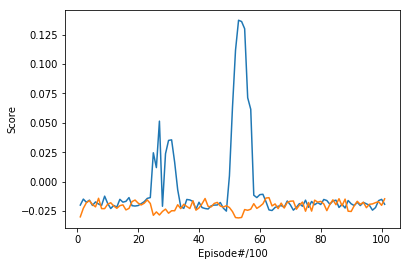

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(1, avg_rewards.shape[0]+1), avg_rewards[:,0])
ax.plot(np.arange(1, avg_rewards.shape[0]+1), avg_rewards[:,1])
plt.ylabel('Score')
plt.xlabel('Episode#/100')
plt.show()

In [11]:
env.close()